### Imports

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')

### Define Variables

In [10]:
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Number of Tnx Error',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'avg gas fee', 'total transactions (including tnx to create contract)',
       'total ether received', 'total ether balance', 'Received Tnx',
                'Sent tnx', 'total Ether sent', 'max val sent',
                'min gas fee', 'max gas fee', 'total gas fee',
                'Unique Sent To Addresses']

In [11]:
cols_to_drop = ['total ether sent contracts',
                'max val sent to contract',
                'min value sent to contract',
                'avg value sent to contract',
                'Number of Created Contracts',
                ]

In [12]:
col = ['Address', 'FLAG']

In [13]:
data_path = "/content/drive/MyDrive/Colab Notebooks/Data/address_data_combined.csv"

In [14]:
df = pd.read_csv(data_path).drop(columns=cols_to_drop)

In [15]:
df.columns

Index(['Address', 'Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)', 'Sent tnx', 'Received Tnx',
       'Number of Tnx Error', 'Unique Received From Addresses',
       'Unique Sent To Addresses', 'min value received', 'max value received ',
       'avg val received', 'min val sent', 'max val sent', 'avg val sent',
       'min gas fee', 'max gas fee', 'avg gas fee',
       'total transactions (including tnx to create contract)',
       'total Ether sent', 'total ether received', 'total gas fee',
       'total ether balance', 'FLAG'],
      dtype='object')

In [16]:
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

In [17]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [18]:
scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [19]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',        # metric for scoring
                   cv=10)                     # number of folds
start_time = time.time()
clf.fit(X_train_full ,y_train_full)
print(time.time() - start_time)

840.1975829601288


In [20]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Train F1 Score :",clf.best_score_)
best_y_pr = clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l2', 'solver': 'liblinear'}
Train F1 Score : 0.8668354993675333
Test F1 Score:  0.8647862750799652


In [21]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
logreg = LogisticRegression(C=1000,penalty="l1",solver='liblinear')
logreg.fit(X_train_full,y_train_full)
y_pred = logreg.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.8616773442050086
0.8356332233018736
0.863941605839416
0.8399865251810679
0.8594249201277955


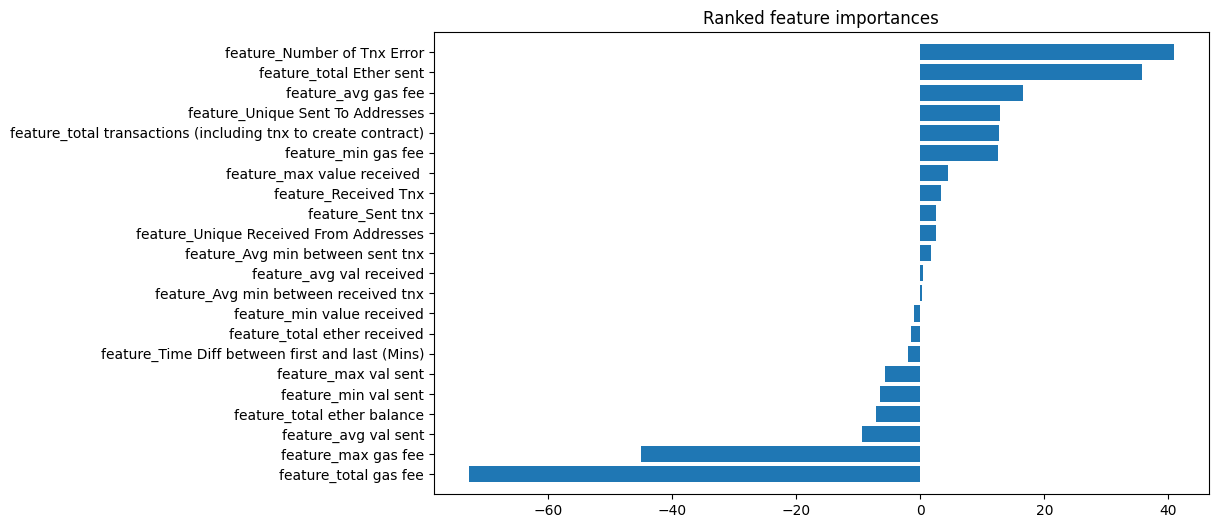

In [22]:
feat_importances = clf.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();